<a href="https://colab.research.google.com/github/harinig07/Content-Based-Image-Retrieval/blob/main/MalayaKew_datatset_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import pickle
import random
import ast
from scipy.cluster.vq import kmeans,vq
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path='/content/drive/MyDrive/train_MK'

In [ ]:
img_with_class=[]
i=0
for classes in os.listdir(train_path):
  for imgs in os.listdir(os.path.join(train_path,classes)):
    img1=cv2.imread(os.path.join(train_path,classes,imgs))
    img_class = i
    temp=[img1,img_class]
    img_with_class.append(temp)
  i=i+1
  print("{} classes completed".format(i))

1 classes completed
2 classes completed
3 classes completed
4 classes completed
5 classes completed
6 classes completed
7 classes completed
8 classes completed
9 classes completed
10 classes completed


In [ ]:
len(img_with_class)

500

In [ ]:
test_sample_index=[]
for i in range(10):
  start=i*50
  end=(i+1)*50-1
  list1=list(range(start,end+1))
  random.seed(42)
  indices=random.sample(list1,5)
  test_sample_index+=indices

In [ ]:
test_sample_index

In [ ]:
def find_distance(feature_vectors):
    D = distance.squareform(distance.pdist(feature_vectors, 'cosine') )
    return D

In [ ]:
def extract_features(img):
  img_to_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  sift=cv2.xfeatures2d.SIFT_create(contrastThreshold=0.0)
  kp1, des1 = sift.detectAndCompute(img_to_gray, None)
  return des1

In [ ]:
features=[]
train_index=[]
for i in range(len(img_with_class)):
  if i not in test_sample_index:
      img=img_with_class[i][0]
      features.append(extract_features(img))
      train_index.append(i)
features1=np.vstack(features)

In [ ]:
'''
train_img_names_path = '/content/drive/MyDrive/cv_project1/model/'
with open(train_img_names_path+"train_indices_malayakew.txt",'w') as f:
  f.write(str(train_index))
'''

In [ ]:
def kmean_cluster(stacked_features,n_clusters,model_name):
  start=time.time()
  model,y=kmeans(np.float32(stacked_features),n_clusters)

  #saving the model
  model_path = '/content/drive/MyDrive/cv_project1/model/'
  with open(model_path + model_name, "wb") as f:
    pickle.dump(model, f)
  end=time.time()
  print('Time take to cluster{}'.format(start-end))
  return model


In [ ]:
def create_bow(features_set,model,n_clusters,bow_model_name):
  bow=[]
  for f in features:
    f=np.vstack(f)
    code,distortion=vq(f,model)
    bow1_hist,_=np.histogram(code,n_clusters)
    bow.append(bow1_hist)

  temparr = np.vstack(bow)
  fv = np.reshape(temparr, (temparr.shape[0], temparr.shape[1]))
  
  #Saving the bow for image representation
  model_path = '/content/drive/MyDrive/cv_project1/model/'
  with open(model_path + bow_model_name, "wb") as f:
    pickle.dump(fv, f)
  return bow

In [ ]:
def create_tf_idf(bow,tf_idf_model_name):
  transformer =  TfidfTransformer(smooth_idf=True)
  t = transformer.fit_transform(bow).toarray()
  t = normalize(t, norm='l2', axis=1)
  model_path = '/content/drive/MyDrive/cv_project1/model/'
  with open(model_path + tf_idf_model_name, "wb") as f:
    pickle.dump(t, f)

In [ ]:
#Run this cell by uncommenting only if the changes is required in image dictionary
'''
#model with 25 visual words
model_name="model_25_wang.pkl"
model_25=kmean_cluster(features1,25,model_name)
bow_name="model_bow_25_wang.pkl"
bow_25=create_bow(features,model_25,25,bow_model_name)
bow_25=np.vstack(bow_25)
tfidf_model_name="tfidf_model_25_wang.pkl"
create_tf_idf(bow_25,tfidf_model_name)

#model with 30 visual words
model_name="model_30_wang.pkl"
model_30=kmean_cluster(features1,30,model_name)
bow_name="model_bow_30.pkl"
bow_30=create_bow(features,model_30,30,bow_model_name)
bow_30=np.vstack(bow_30)
tfidf_model_name="tfidf_model_30_wang.pkl"
create_tf_idf(bow_30,tfidf_model_name)

#model with 50 visual words
model_name="model_50_wang.pkl"
model_50=kmean_cluster(features1,50,model_name)
bow_name="model_bow_50.pkl"
bow_50=create_bow(features,model_50,50,bow_model_name)
bow_50=np.vstack(bow_50)
tfidf_model_name="tfidf_model_50_wang.pkl"
create_tf_idf(bow_50,tfidf_model_name)

'''

In [ ]:
def find_match_imgs_and_evaluate(test_img,test_img_idx,model,n_clusters,model_bow,n_retrieved,train_index):
  test_image_features=extract_features(test_img)
  test_image_features=np.vstack(test_image_features)
  test_image_features.shape

  code_test,distortion_test=vq(test_image_features,model)
  bow_test_hist,_=np.histogram(code_test,model.shape[0])


  feat_vect=model_bow
  feat_vect=np.insert(feat_vect,0,bow_test_hist,axis=0)
  
  D=find_distance(feat_vect)
  nearest_idx = np.argsort(D[0, :])
  
  retrieved_indices=[]
  for i in range(1,n_retrieved+1):
      train_img_name=train_index[nearest_idx[i]]
      retrieved_indices.append(train_img_name)
      #img_retrieved=img_with_class[train_img_name][0]
      #plt.imshow(img_retrieved)
      #plt.show()
  
  #to see histogram of each images
  '''
  for i in range(1,n_retrieved+1):
    retrieved_image_features=extract_features(img_retrieved)
    retrieved_image_features=np.vstack(retrieved_image_features)
    code_img,distortion_img=vq(retrieved_image_features,model)
    plt.hist(code_img,bins=25,edgecolor='black')
    plt.show()
  ''' 

 
 
  count_tp=0
  count=0
  precision=[]
  recall=[]
  for x in retrieved_indices:
    if img_with_class[x][1] == img_with_class[test_img_idx][1]:
      count_tp+=1
      count+=1
      temp_precision=count_tp/count
      temp_recall=count_tp/45
      precision.append(temp_precision)
      recall.append(temp_recall)
    else:
      count+=1
      temp_precision=count_tp/count
      temp_recall=count_tp/45
      precision.append(temp_precision)
      recall.append(temp_recall)
     
  return precision,recall

Query evaluation

In [ ]:
train_img_names_path = '/content/drive/MyDrive/cv_project1/model/'
with open(train_img_names_path+'train_indices_malayakew.txt','r') as f:
 num_list=f.read()
train_index = ast.literal_eval(num_list)


In [ ]:
test_img_index = random.choice(test_sample_index)
test_img_index

190

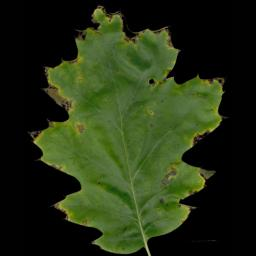

In [ ]:
test_img=img_with_class[test_img_index][0]
cv2_imshow(test_img)

In [ ]:
model_path='/content/drive/MyDrive/cv_project1/model/model_25_malayakew.pkl'
with open(model_path, "rb") as f:
    model = pickle.load(f)

In [ ]:
bow_name="model_bow_25_malaykew.pkl"
bow_model=create_bow(features,model,25,bow_name)

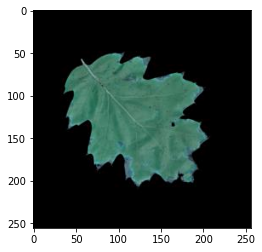

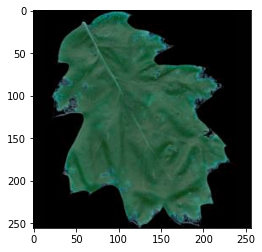

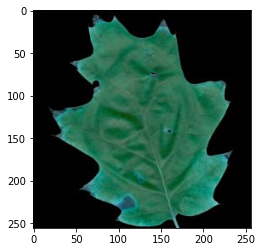

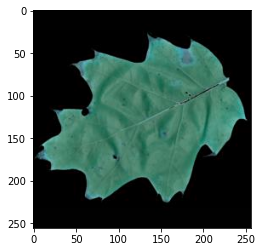

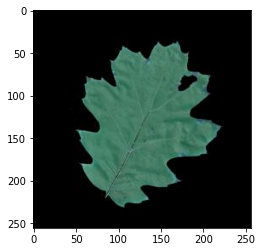

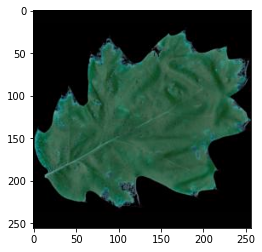

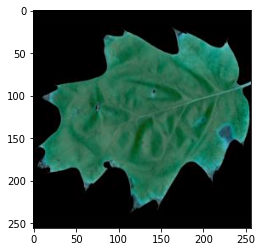

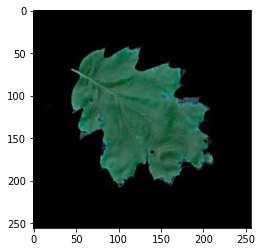

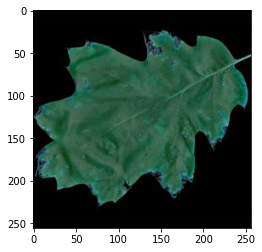

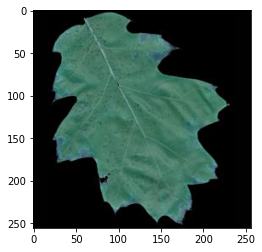

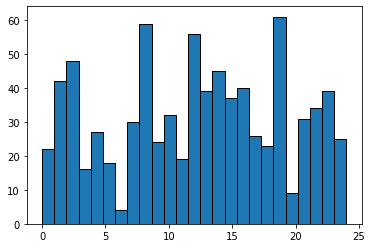

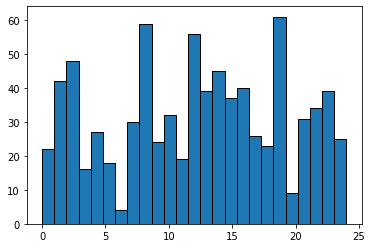

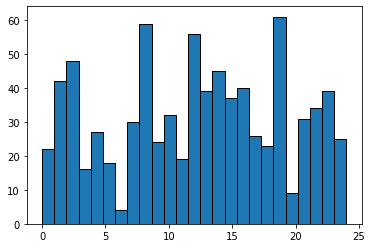

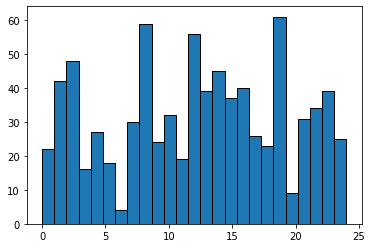

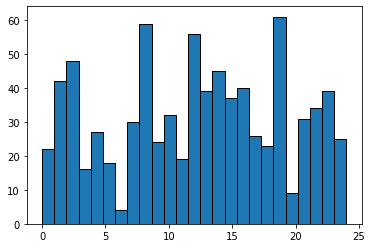

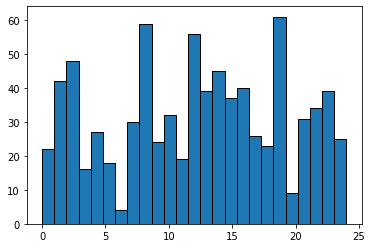

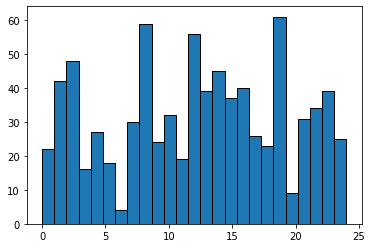

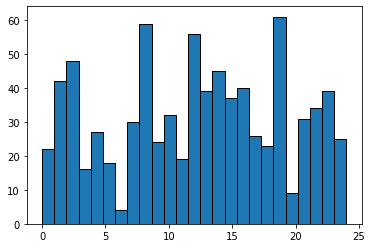

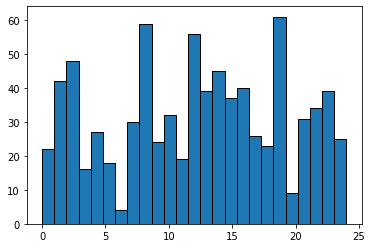

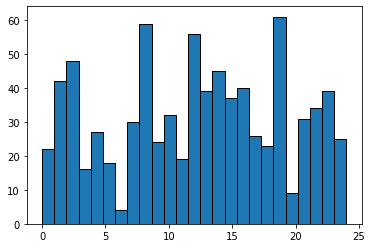

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,test_img_index,model,25,bow_model,10,train_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.022222222222222223, 0.044444444444444446, 0.06666666666666667, 0.08888888888888889, 0.1111111111111111, 0.13333333333333333, 0.15555555555555556, 0.17777777777777778, 0.2, 0.2222222222222222]
Mean of precision is 1.0
Mean of recall is 0.12222222222222223


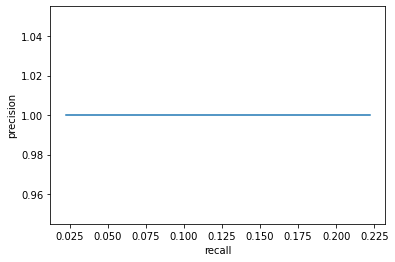

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,test_img_index,model,25,bow_model,20,train_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9333333333333333, 0.9333333333333333, 0.8823529411764706, 0.8823529411764706, 0.8421052631578947, 0.8421052631578947]
[0.022222222222222223, 0.044444444444444446, 0.06666666666666667, 0.08888888888888889, 0.1111111111111111, 0.13333333333333333, 0.15555555555555556, 0.17777777777777778, 0.2, 0.2222222222222222, 0.24444444444444444, 0.26666666666666666, 0.26666666666666666, 0.28888888888888886, 0.3111111111111111, 0.3111111111111111, 0.3333333333333333, 0.3333333333333333, 0.35555555555555557, 0.35555555555555557]
Mean of precision is 0.9622077251953411
Mean of recall is 0.2144444444444445


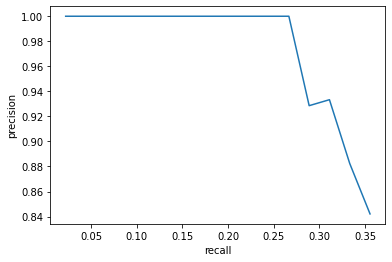

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [ ]:
model_bow=np.vstack(bow_model)
tfidf_model_name="tfidf_model_25_malayakew.pkl"
create_tf_idf(model_bow,tfidf_model_name)

In [ ]:
model_path='/content/drive/MyDrive/cv_project1/model/tfidf_model_25_malayakew.pkl'
with open(model_path, "rb") as f:
    model_tfidf = pickle.load(f)

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,test_img_index,model,25,model_tfidf,10,train_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.022222222222222223, 0.044444444444444446, 0.06666666666666667, 0.08888888888888889, 0.1111111111111111, 0.13333333333333333, 0.15555555555555556, 0.17777777777777778, 0.2, 0.2222222222222222]
Mean of precision is 1.0
Mean of recall is 0.12222222222222223


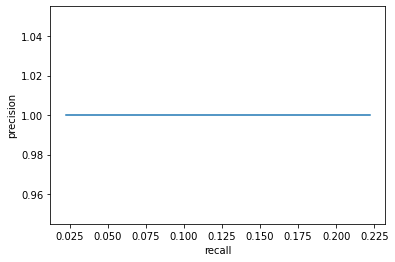

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,test_img_index,model,25,model_tfidf,20,train_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286, 0.9285714285714286, 0.875, 0.8823529411764706, 0.8888888888888888, 0.8888888888888888, 0.85]
[0.022222222222222223, 0.044444444444444446, 0.06666666666666667, 0.08888888888888889, 0.1111111111111111, 0.13333333333333333, 0.15555555555555556, 0.17777777777777778, 0.2, 0.2222222222222222, 0.24444444444444444, 0.26666666666666666, 0.26666666666666666, 0.28888888888888886, 0.28888888888888886, 0.3111111111111111, 0.3333333333333333, 0.35555555555555557, 0.35555555555555557, 0.37777777777777777]
Mean of precision is 0.9621136788048554
Mean of recall is 0.21555555555555558


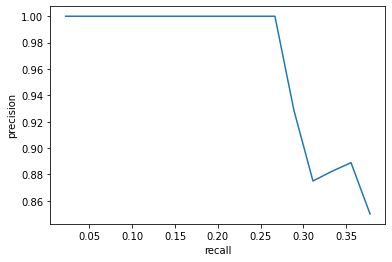

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

30 visual words

In [ ]:
model_path='/content/drive/MyDrive/cv_project1/model/model_30_malayakew.pkl'
with open(model_path, "rb") as f:
    model = pickle.load(f)

In [ ]:
bow_name="model_bow_30_malaykew.pkl"
bow_model=create_bow(features,model,30,bow_name)

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,test_img_index,model,30,bow_model,10,train_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.022222222222222223, 0.044444444444444446, 0.06666666666666667, 0.08888888888888889, 0.1111111111111111, 0.13333333333333333, 0.15555555555555556, 0.17777777777777778, 0.2, 0.2222222222222222]
Mean of precision is 1.0
Mean of recall is 0.12222222222222223


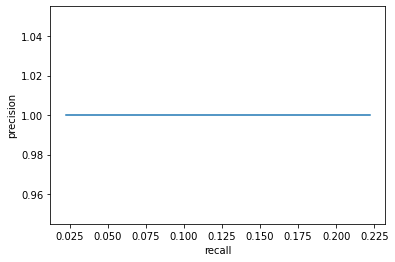

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,test_img_index,model,30,bow_model,20,train_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 0.9230769230769231, 0.9285714285714286, 0.9333333333333333, 0.9375, 0.9411764705882353, 0.9444444444444444, 0.9473684210526315, 0.95]
[0.022222222222222223, 0.044444444444444446, 0.06666666666666667, 0.08888888888888889, 0.1111111111111111, 0.13333333333333333, 0.15555555555555556, 0.17777777777777778, 0.2, 0.2222222222222222, 0.2222222222222222, 0.24444444444444444, 0.26666666666666666, 0.28888888888888886, 0.3111111111111111, 0.3333333333333333, 0.35555555555555557, 0.37777777777777777, 0.4, 0.4222222222222222]
Mean of precision is 0.971106884386683
Mean of recall is 0.22222222222222224


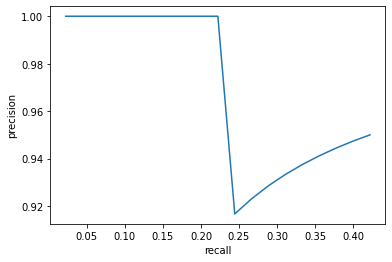

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [ ]:
model_bow=np.vstack(bow_model)
tfidf_model_name="tfidf_model_30_malayakew.pkl"
create_tf_idf(model_bow,tfidf_model_name)

In [ ]:
model_path='/content/drive/MyDrive/cv_project1/model/tfidf_model_30_malayakew.pkl'
with open(model_path, "rb") as f:
    model_tfidf = pickle.load(f)

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,test_img_index,model,30,model_tfidf,10,train_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.022222222222222223, 0.044444444444444446, 0.06666666666666667, 0.08888888888888889, 0.1111111111111111, 0.13333333333333333, 0.15555555555555556, 0.17777777777777778, 0.2, 0.2222222222222222]
Mean of precision is 1.0
Mean of recall is 0.12222222222222223


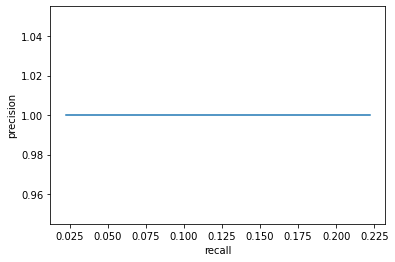

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,test_img_index,model,30,model_tfidf,20,train_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9333333333333333, 0.9375, 0.9411764705882353, 0.9444444444444444, 0.9473684210526315, 0.95]
[0.022222222222222223, 0.044444444444444446, 0.06666666666666667, 0.08888888888888889, 0.1111111111111111, 0.13333333333333333, 0.15555555555555556, 0.17777777777777778, 0.2, 0.2222222222222222, 0.24444444444444444, 0.26666666666666666, 0.28888888888888886, 0.28888888888888886, 0.3111111111111111, 0.3333333333333333, 0.35555555555555557, 0.37777777777777777, 0.4, 0.4222222222222222]
Mean of precision is 0.9826911334709321
Mean of recall is 0.2255555555555556


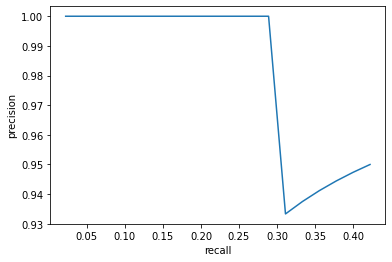

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

50 visual words

In [155]:
model_path='/content/drive/MyDrive/cv_project1/model/model_50_malayakew.pkl'
with open(model_path, "rb") as f:
    model = pickle.load(f)

In [156]:
bow_name="model_bow_50_malaykew.pkl"
bow_model=create_bow(features,model,50,bow_name)

In [157]:
precision,recall=find_match_imgs_and_evaluate(test_img,test_img_index,model,50,bow_model,10,train_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.022222222222222223, 0.044444444444444446, 0.06666666666666667, 0.08888888888888889, 0.1111111111111111, 0.13333333333333333, 0.15555555555555556, 0.17777777777777778, 0.2, 0.2222222222222222]
Mean of precision is 1.0
Mean of recall is 0.12222222222222223


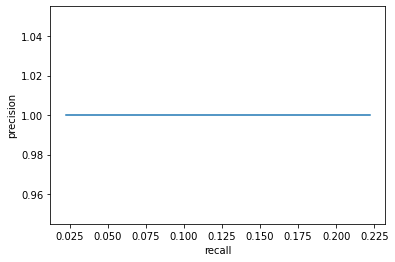

In [158]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [159]:
precision,recall=find_match_imgs_and_evaluate(test_img,test_img_index,model,50,bow_model,20,train_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9375, 0.9411764705882353, 0.9444444444444444, 0.9473684210526315, 0.95]
[0.022222222222222223, 0.044444444444444446, 0.06666666666666667, 0.08888888888888889, 0.1111111111111111, 0.13333333333333333, 0.15555555555555556, 0.17777777777777778, 0.2, 0.2222222222222222, 0.24444444444444444, 0.26666666666666666, 0.28888888888888886, 0.3111111111111111, 0.3333333333333333, 0.3333333333333333, 0.35555555555555557, 0.37777777777777777, 0.4, 0.4222222222222222]
Mean of precision is 0.9860244668042654
Mean of recall is 0.2277777777777778


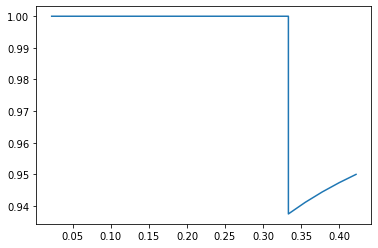

In [160]:
print(precision)
print(recall)
plt.plot(recall,precision)
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [161]:
model_bow=np.vstack(bow_model)
tfidf_model_name="tfidf_model_50_malayakew.pkl"
create_tf_idf(model_bow,tfidf_model_name)

In [162]:
model_path='/content/drive/MyDrive/cv_project1/model/tfidf_model_50_malayakew.pkl'
with open(model_path, "rb") as f:
    model_tfidf = pickle.load(f)

In [163]:
precision,recall=find_match_imgs_and_evaluate(test_img,test_img_index,model,50,model_tfidf,10,train_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.022222222222222223, 0.044444444444444446, 0.06666666666666667, 0.08888888888888889, 0.1111111111111111, 0.13333333333333333, 0.15555555555555556, 0.17777777777777778, 0.2, 0.2222222222222222]
Mean of precision is 1.0
Mean of recall is 0.12222222222222223


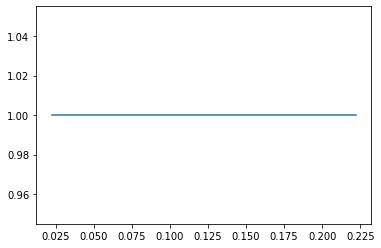

In [164]:
print(precision)
print(recall)
plt.plot(recall,precision)
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [165]:
precision,recall=find_match_imgs_and_evaluate(test_img,test_img_index,model,50,model_tfidf,20,train_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9375, 0.9411764705882353, 0.9444444444444444, 0.9473684210526315, 0.95]
[0.022222222222222223, 0.044444444444444446, 0.06666666666666667, 0.08888888888888889, 0.1111111111111111, 0.13333333333333333, 0.15555555555555556, 0.17777777777777778, 0.2, 0.2222222222222222, 0.24444444444444444, 0.26666666666666666, 0.28888888888888886, 0.3111111111111111, 0.3333333333333333, 0.3333333333333333, 0.35555555555555557, 0.37777777777777777, 0.4, 0.4222222222222222]
Mean of precision is 0.9860244668042654
Mean of recall is 0.2277777777777778


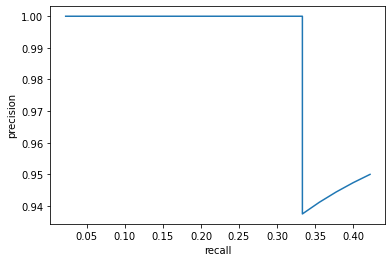

In [166]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,test_img_index,model,50,bow_model,45,train_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411764705882353, 0.9444444444444444, 0.9473684210526315, 0.95, 0.95, 0.95, 0.8695652173913043, 0.875, 0.88, 0.8846153846153846, 0.8846153846153846, 0.8571428571428571, 0.8620689655172413, 0.8666666666666667, 0.8709677419354839, 0.875, 0.8787878787878788, 0.8787878787878788, 0.8571428571428571, 0.8611111111111112, 0.8611111111111112, 0.8611111111111112, 0.8205128205128205, 0.825, 0.8292682926829268, 0.8292682926829268, 0.8292682926829268, 0.7954545454545454, 0.8]
[0.022222222222222223, 0.044444444444444446, 0.06666666666666667, 0.08888888888888889, 0.1111111111111111, 0.13333333333333333, 0.15555555555555556, 0.17777777777777778, 0.2, 0.2222222222222222, 0.24444444444444444, 0.26666666666666666, 0.28888888888888886, 0.3111111111111111, 0.3333333333333333, 0.3333333333333333, 0.35555555555555557, 0.37777777777777777, 0.4, 0.4222222222222222, 0.4222222222222222, 0.4222222222222222, 0.4444444444444444, 0.46

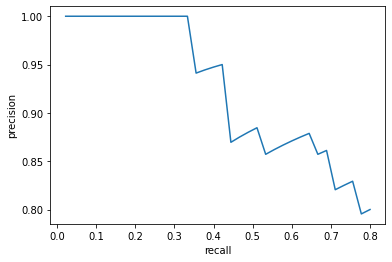

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,test_img_index,model,50,model_tfidf,45,train_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411764705882353, 0.9444444444444444, 0.9473684210526315, 0.95, 0.95, 0.95, 0.8695652173913043, 0.875, 0.88, 0.88, 0.8518518518518519, 0.8571428571428571, 0.8620689655172413, 0.8666666666666667, 0.8709677419354839, 0.875, 0.8787878787878788, 0.8823529411764706, 0.8823529411764706, 0.8823529411764706, 0.8378378378378378, 0.8378378378378378, 0.8205128205128205, 0.825, 0.8292682926829268, 0.8292682926829268, 0.8292682926829268, 0.7954545454545454, 0.7954545454545454]
[0.022222222222222223, 0.044444444444444446, 0.06666666666666667, 0.08888888888888889, 0.1111111111111111, 0.13333333333333333, 0.15555555555555556, 0.17777777777777778, 0.2, 0.2222222222222222, 0.24444444444444444, 0.26666666666666666, 0.28888888888888886, 0.3111111111111111, 0.3333333333333333, 0.3333333333333333, 0.35555555555555557, 0.37777777777777777, 0.4, 0.4222222222222222, 0.4222222222222222, 0.4222222222222222, 0.4444444444444444, 0.4

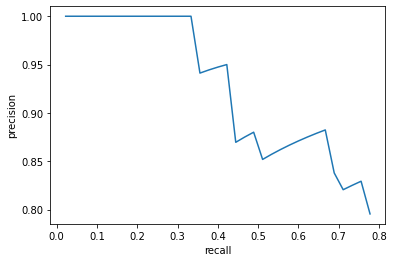

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))